## Import libraries

In [1]:
# Standard imports
import os
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.feature_selection import f_classif
from shapely.geometry import Polygon
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Deep learning libraries
# import torch
# from torchvision import datasets, models, transforms

In [2]:
print(ee.__version__)

# Melakukan Autentikasi Pengguna. Klik link yang muncul, kemudian copykan
# token yang diperoleh ke kolom yang tersedia
ee.Authenticate()

# Mengaktifkan GEE pada Google Colab
ee.Initialize(project='ee-atlk')

1.4.0


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


## Daerah prediksi

### Buat polygon daerah yang ingin diprediksi

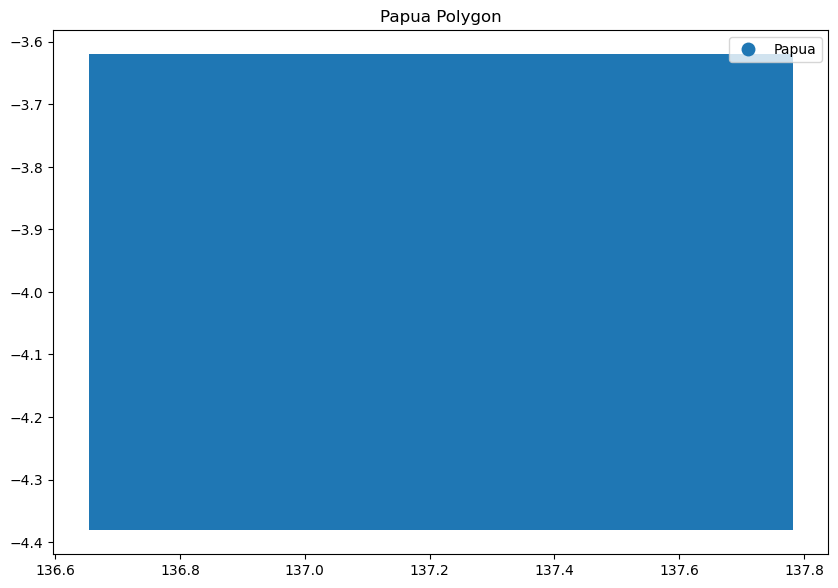

In [3]:
# Define the Papua polygon as a Shapely Polygon
papua_polygon = Polygon([
    [136.6536846864052, -3.619622937960064],
    [136.6536846864052, -4.3813066778891825],
    [137.78252990124895, -4.3813066778891825],
    [137.78252990124895, -3.619622937960064]
])

# Create a GeoDataFrame for the polygon
papua_gdf = gpd.GeoDataFrame({'shapeName': ['Papua'], 'geometry': [papua_polygon]}, crs="EPSG:4326")

# Plot the GeoDataFrame
fig, ax = plt.subplots(1, figsize=(10, 10))
papua_gdf.plot('shapeName', legend=True, ax=ax)

# Set the plot title and show the plot
ax.set_title("Papua Polygon")
plt.show()

### Buat tampilan citra satelit yang ingin diprediksi

In [6]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2018-01-01',
    max_date='2020-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generates cloud-filtered, median-aggregated
    Sentinel-2 image from Google Earth Engine using the
    Pythin Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 image clipped to the region of interest
    """

    # Generate median aggregated composite
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()
    # Get RGB bands
    # image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

In [20]:
# Get the centroid of the polygon
centroid = papua_polygon.centroid.coords[0]
region = gpd.GeoDataFrame({'geometry': [papua_polygon]}, crs="EPSG:4326")
region = eec.gdfToFc(region) #geodataframe to feature collection

# Generate RGB image using GEE
image = generate_image(
    region,
    product='COPERNICUS/S2_SR_HARMONIZED', # Sentinel-2A
    min_date='2023-06-01', # Get all images within
    max_date='2024-12-31', # the year 2021
    cloud_pct=30, # Filter out images with cloud cover >= 10.0%
)

# Visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image.visualize(bands=['B4', 'B3', 'B2'], min=0, max=2000), {}, 'Sentinel2')
Map.addLayerControl()
Map

In [50]:
# Get the band names from the Sentinel-2 image
band_names = image.bandNames().getInfo()

# Print the band names
print("Band Names:", band_names)


Band Names: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE']


### Export citra satelit

In [6]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.

    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region,
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()

    return task

In [7]:
# Uncomment if wanted to download new image
# Convert Shapely Polygon coordinates to a format compatible with ee.Geometry.Polygon
papua_coords = [list(papua_polygon.exterior.coords)]
# Create an ee.Geometry.Polygon from the coordinates
papua_ee_geometry = ee.Geometry.Polygon(papua_coords)

folder = 'TA'  # Change this to your destination folder in Google Drive
task = export_image(image, 'Papua_Image', papua_ee_geometry, folder)

Exporting to Papua_Image.tif ...


In [8]:
task.status()

{'state': 'READY',
 'description': 'Papua_Image',
 'priority': 100,
 'creation_timestamp_ms': 1732194041042,
 'update_timestamp_ms': 1732194041042,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'BGIC5JGRPTD45IEBXTJHPM4F',
 'name': 'projects/ee-atlk/operations/BGIC5JGRPTD45IEBXTJHPM4F'}

### Visualisasi image yang sudah diexport

c:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


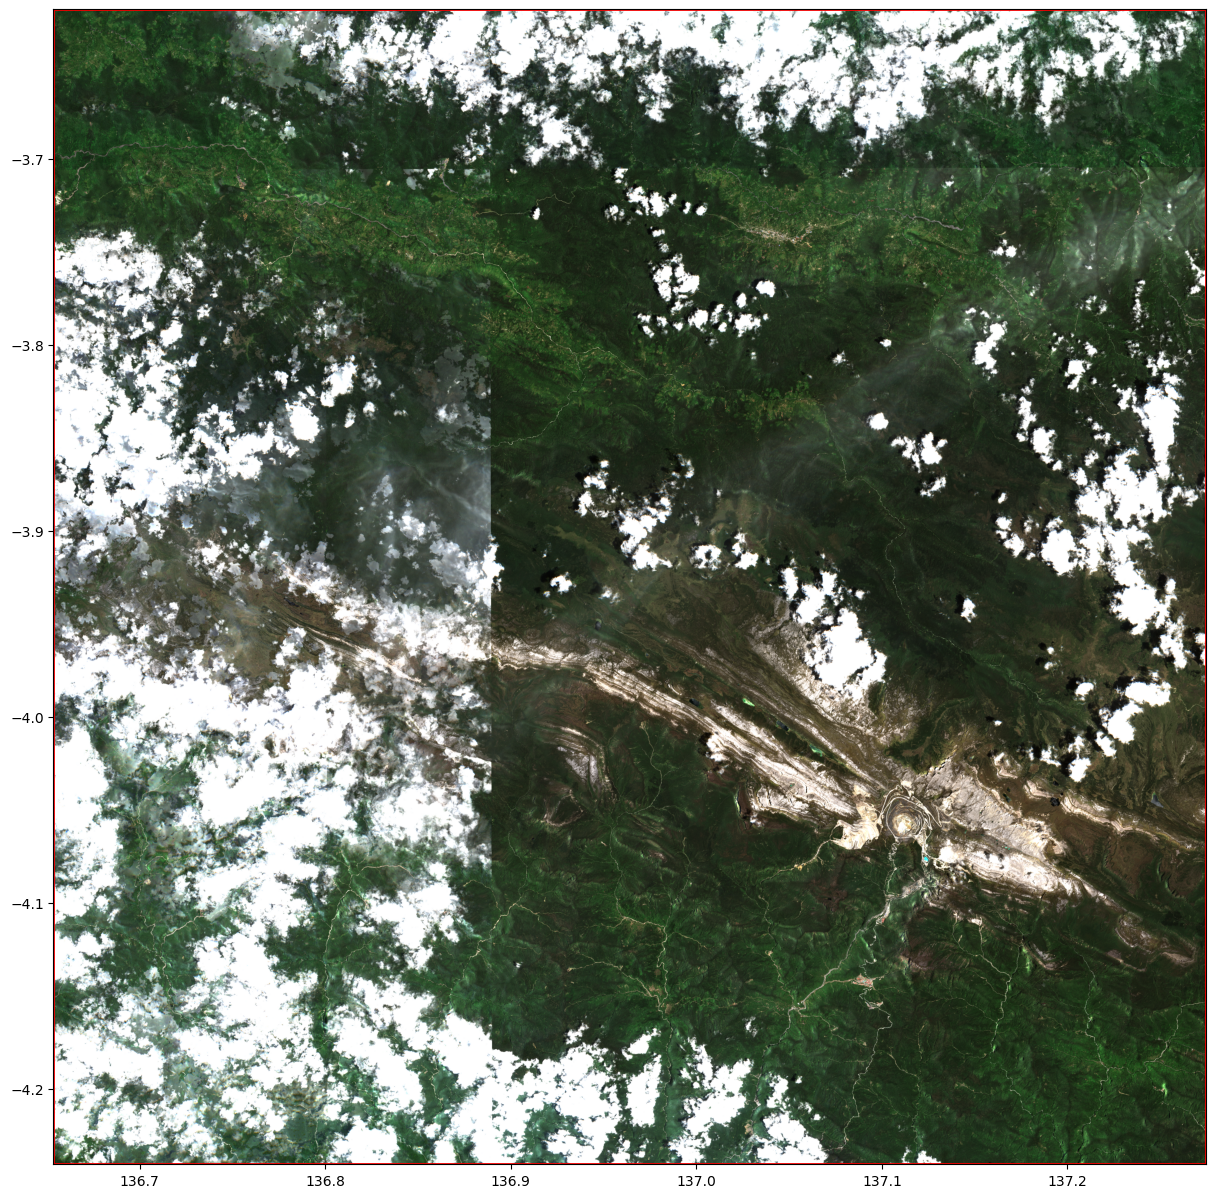

In [9]:
# Set file path
tif_file = ('../data/Papua_Image-0000000000-0000000000.tif')

# Open the image file using Rasterio
image = rio.open(tif_file)

# Get the bounding box in the image's coordinate system
bounds = image.bounds
crs = image.crs  # get the CRS

# Create a Shapely box (polygon) from the bounds
tif_boundary = gpd.GeoDataFrame({'geometry': [box(bounds.left, bounds.bottom, bounds.right, bounds.top)]}, crs=crs)

# Initialize a plot for all images and boundaries
fig, ax = plt.subplots(figsize=(15, 15))

# Read bands 4, 3, and 2 (assuming they're in this order: band1 -> index 1, band2 -> index 2, etc.)
rgb = image.read([4, 3, 2])  # Reading bands 4, 3, and 2

# Normalize to range [0, 1]
rgb = rgb / 2000.0  # Adjust divisor based on your data's max value
rgb = np.clip(rgb, 0, 1)  # Clip values to ensure they are within [0, 1]

# Display the RGB composite and plot the boundary
show(rgb, ax=ax, transform=image.transform)
tif_boundary.plot(facecolor="none", edgecolor='red', linewidth=2, ax=ax)

plt.show()

### Load data image

In [51]:
# Load sentinel image
# Define the list of TIF file paths
tif_image = rio.open(tif_file)
# Read the image and normalize it by dividing by 1e4
image_data = tif_image.read() / 1e4

## Hasil labeling

### Import hasil labeling

In [14]:
with open ('../data/tambang_papua.geojson', 'r') as file:
    sample_data = geojson.load(file)

# # Now, let's print the GeoJSON data to understand its structure
# pp.pprint(dict(sample_data))

sample_data['features'][0]['properties']['name'] = 'tambang'
sample_data['features'][1]['properties']['name'] = 'non_tambang'
sample_data['features'][0]['properties']['label'] = '1'
sample_data['features'][1]['properties']['label'] = '0'

### Ubah menjadi dataframe

In [35]:
# Initialize a list to hold the data
data = []

# Iterate over each feature in the GeoJSON
for feature in sample_data['features']:
    # Extract coordinates (for MultiPoint, it's a list of points)
    coordinates = feature['geometry']['coordinates']

    # Extract label from properties
    label = feature['properties']['label']
    name = feature['properties']['name']

    # Iterate over the points in the MultiPoint geometry
    for coord in coordinates:
        # Append a dictionary with the coordinates and label
        data.append({
            'longitude': coord[0],
            'latitude': coord[1],
            'label': label,
            'name': name
        })

# Create a DataFrame from the data list
sample = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(sample.head())
print(sample.shape)

    longitude  latitude label     name
0  107.586895 -3.004447     1  tambang
1  107.589878 -3.004222     1  tambang
2  107.590961 -3.001790     1  tambang
3  137.037831 -4.023746     1  tambang
4  137.015858 -3.996347     1  tambang
(1000, 4)


In [32]:
# Initialize a list to hold the data
coords = []

# Iterate over each feature in the GeoJSON
for feature in sample_data['features']:
    # Extract coordinates (for MultiPoint, it's a list of points)
    coordinates = feature['geometry']['coordinates']

    # Extract label from properties
    # label = feature['properties']['label']

    # Iterate over the points in the MultiPoint geometry
    for coord in coordinates:
        # Append a dictionary with the coordinates and label
        coords.append((coord[0], coord[1]))

print(coords)

[(107.586895, -3.004447), (107.589878, -3.004222), (107.590961, -3.00179), (137.037831, -4.023746), (137.015858, -3.996347), (137.063237, -4.040185), (137.132588, -4.03128), (137.1731, -4.059363), (137.156621, -4.077855), (137.337895, -4.080595), (137.349568, -4.088814), (136.901875, -3.965523), (136.924534, -3.966893), (136.936894, -4.025801), (137.312489, -4.062102), (137.305303, -4.068716), (137.319551, -4.076507), (137.180391, -4.037115), (137.185198, -4.041567), (137.166315, -4.029666), (137.146316, -4.042595), (137.092758, -4.060574), (137.091213, -4.050471), (137.111555, -4.056721), (137.080249, -4.048759), (137.06377, -4.031978), (137.046766, -4.029564), (137.042903, -4.043948), (137.030887, -4.009016), (137.023162, -4.016208), (137.077078, -4.010879), (137.085232, -4.008996), (137.08918, -3.99855), (137.081756, -3.994654), (137.061742, -3.98366), (137.065532, -3.958829), (137.065189, -3.968076), (136.977678, -3.989728), (136.960511, -3.982364), (136.870561, -3.959588), (136.94

### Extract raster values

longitude  latitude label         name      B1      B2      B3      B4  \
0    107.586895 -3.004447     1      tambang  0.0000  0.0000  0.0000  0.0000   
1    107.589878 -3.004222     1      tambang  0.0000  0.0000  0.0000  0.0000   
2    107.590961 -3.001790     1      tambang  0.0000  0.0000  0.0000  0.0000   
3    137.037831 -4.023746     1      tambang  0.1615  0.1988  0.2012  0.2142   
4    137.015858 -3.996347     1      tambang  0.1403  0.1468  0.1648  0.1700   
..          ...       ...   ...          ...     ...     ...     ...     ...   
995  137.132086 -4.185353     0  non_tambang  0.0195  0.0171  0.0368  0.0221   
996  136.941198 -4.107281     0  non_tambang  0.0221  0.0210  0.0358  0.0236   
997  136.912359 -4.166863     0  non_tambang  0.0348  0.0268  0.0369  0.0253   
998  137.013983 -4.168233     0  non_tambang  0.0328  0.0295  0.0488  0.0328   
999  137.161362 -4.200288     0  non_tambang  0.0251  0.0248  0.0435  0.0293   

         B5      B6      B7      B8     B8A      B9     B11     B12  
0    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
1    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
2    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
3    0.2133  0.2219  0.2484  0.2945  0.3081  0.2592  0.5664  0.4847  
4    0.1910  0.2143  0.2410  0.2718  0.3065  0.2602  0.5160  0.4221  
..      ...     ...     ...     ...     ...     ...     ...     ...  
995  0.0740  0.2146  0.2620  0.2612  0.2818  0.2581  0.1293  0.0543  
996  0.0650  0.1858  0.2280  0.2501  0.2605  0.2502  0.1305  0.0580  
997  0.0686  0.1763  0.2013  0.2038  0.2500  0.2860  0.1326  0.0618  
998  0.0949  0.2132  0.2487  0.2284  0.2726  0.2600  0.1475  0.0702  
999  0.0890  0.2328  0.2726  0.2705  0.3054  0.3372  0.1641  0.0727  

[1000 rows x 16 columns]

c:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\matplotlib\cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


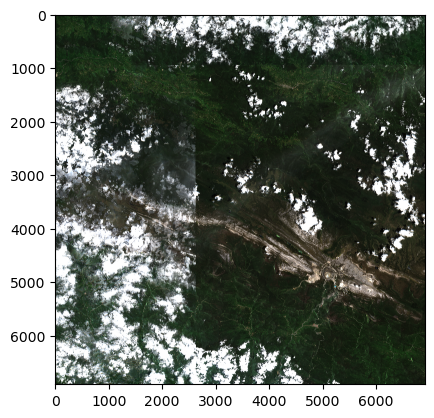

In [93]:
from skimage.exposure import rescale_intensity
sample_extract = sample.copy()
# False color composite
out_range = (0, 1)
red = rescale_intensity(image_data[3], in_range=(0, 0.3), out_range=out_range)  # Band 4 (Red)
green = rescale_intensity(image_data[2], in_range=(0, 0.3), out_range=out_range)  # Band 3 (Green)
blue = rescale_intensity(image_data[1], in_range=(0, 0.3), out_range=out_range)  # Band 2 (Blue)

arr_image = np.stack(
    [red, green, blue]
).T
composite = np.rot90(np.flip(arr_image, 1), 1)

# Plot landsat image
plt.imshow(composite)

# Extract raster value
raster_extract = np.stack(
    [x for x in tif_image.sample(coords)]
) / 1e4
sample_extract[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']] = raster_extract
sample_extract

### Sample split

In [54]:
# Split sample to train and test
seeds = 2
train, test = train_test_split(sample_extract, train_size=0.7, random_state=seeds)
print(f'Train size: {len(train)}\nTest size: {len(test)}')

Train size: 700
Test size: 300


## Modeling

### Buat model menggunakan Random Forest

In [55]:
# Make random forest model
predictors = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
model = RandomForestClassifier(50)
model.fit(
    train[predictors],
    train['label']
)

RandomForestClassifier(n_estimators=50)

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       151
           1       0.94      0.81      0.87       149

    accuracy                           0.88       300
   macro avg       0.89      0.88      0.88       300
weighted avg       0.89      0.88      0.88       300



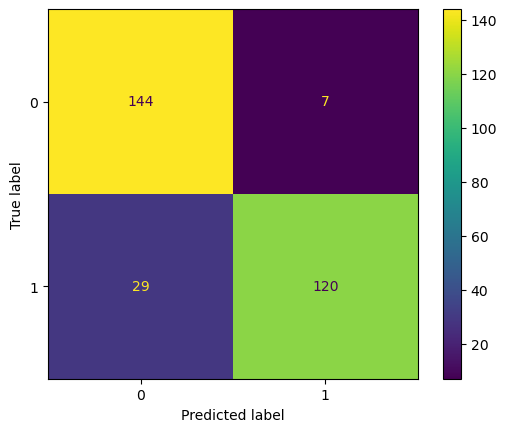

In [56]:
# Test model
test_apply = model.predict(test[predictors])

# Confusion matrix
cm = confusion_matrix(test['label'], test_apply)
display = ConfusionMatrixDisplay(cm)
display.plot()

# Report
report = classification_report(test['label'], test_apply)
print(report)

### Aplikasikan model ke citra

In [57]:
# Load image
image_transpose = image_data.T
transpose_shape = image_transpose.shape
band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
table_image = pd.DataFrame(
    image_transpose.reshape(-1, transpose_shape[2]),
    columns=band_names,
)
table_image

B1      B2      B3      B4      B5      B6      B7      B8  \
0         0.0185  0.0173  0.0389  0.0171  0.0799  0.3064  0.3619  0.3520   
1         0.0174  0.0213  0.0494  0.0209  0.0914  0.3426  0.3965  0.4228   
2         0.0174  0.0252  0.0568  0.0242  0.0914  0.3426  0.3965  0.4200   
3         0.0174  0.0219  0.0458  0.0284  0.0912  0.3244  0.3842  0.3812   
4         0.0174  0.0219  0.0458  0.0284  0.0912  0.3244  0.3842  0.3812   
...          ...     ...     ...     ...     ...     ...     ...     ...   
47775739  0.0272  0.0244  0.0450  0.0251  0.0750  0.2234  0.2735  0.3154   
47775740  0.0272  0.0250  0.0422  0.0272  0.0797  0.2439  0.2987  0.2933   
47775741  0.0272  0.0228  0.0383  0.0262  0.0797  0.2439  0.2987  0.2645   
47775742  0.0272  0.0222  0.0447  0.0256  0.0827  0.2442  0.2965  0.3072   
47775743  0.0272  0.0232  0.0443  0.0285  0.0827  0.2442  0.2965  0.2967   

             B8A      B9     B11     B12  
0         0.3955  0.4177  0.1770  0.0813  
1         0.4473  0.4016  0.1939  0.0873  
2         0.4473  0.4016  0.1939  0.0873  
3         0.4111  0.4016  0.1809  0.0849  
4         0.4111  0.4016  0.1809  0.0849  
...          ...     ...     ...     ...  
47775739  0.2991  0.2966  0.1524  0.0622  
47775740  0.3335  0.2966  0.1609  0.0691  
47775741  0.3335  0.2966  0.1609  0.0691  
47775742  0.3342  0.2966  0.1601  0.0695  
47775743  0.3342  0.2966  0.1601  0.0695  

[47775744 rows x 12 columns]

In [58]:
table_image.to_csv('../data/table_image.csv', index=False)

In [ ]:
table_image = pd.read_csv('../data/table_image.csv')

In [63]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a strategy to fill NaNs, e.g., with the mean value
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data
table_image_imputed = imputer.fit_transform(table_image[predictors])

# Predict with the imputed data
prediction = model.predict(table_image_imputed)
prediction

c:\Users\ASUS\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['0', '0', '0', ..., '0', '0', '0'], dtype=object)

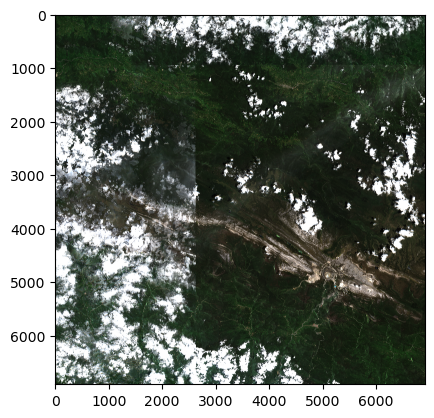

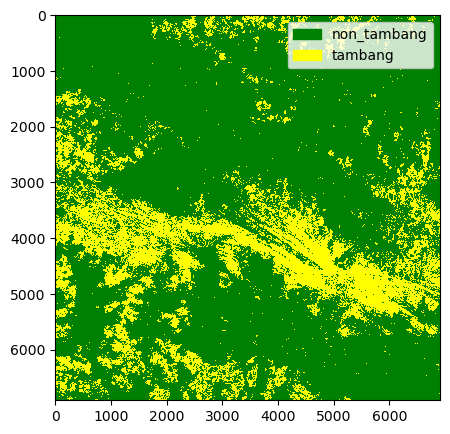

In [91]:
out_range = (0, 1)
red = rescale_intensity(image_data[3], in_range=(0, 0.3), out_range=out_range)  # Band 4 (Red)
green = rescale_intensity(image_data[2], in_range=(0, 0.3), out_range=out_range)  # Band 3 (Green)
blue = rescale_intensity(image_data[1], in_range=(0, 0.3), out_range=out_range)  # Band 2 (Blue)

arr_image = np.stack(
    [red, green, blue]
).T
composite = np.rot90(np.flip(arr_image, 1), 1)

# Plot landsat image
plt.imshow(composite)

# Prediction to image again
prediction = np.array(prediction, dtype=int) 
prediction_image = np.rot90(np.flip(prediction.reshape(transpose_shape[0], transpose_shape[1]), 1), 1)

cmap = ListedColormap(['green', 'yellow'])
legend_labels = [mpatches.Patch(color='green', label='non_tambang'), 
                    mpatches.Patch(color='yellow', label='tambang')]

# Show to plot
plt.figure(figsize=(5, 5))
plt.imshow(prediction_image, cmap=cmap, interpolation="nearest")
plt.legend(handles=legend_labels, loc='upper right')

### Prediksi image Landsat

In [ ]:
# Generate RGB image using GEE
image = generate_image(
    region,
    product='LANDSAT/LC08/C02/T1_RT', # Landsat
    min_date='2023-01-01', # Get all images within
    max_date='2024-08-31', # the year 2021
    cloud_pct=10 # Filter out images with cloud cover >= 10.0%
)

# Visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image.visualize(bands=['B4', 'B3', 'B2'], min=6921, max=44343, gamma=2.454), {}, 'Landsat8')
Map.addLayerControl()
Map

In [83]:
# Get the band names from the Sentinel-2 image
band_names = image.bandNames().getInfo()

# Print the band names
print("Band Names:", band_names)

Band Names: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'QA_PIXEL', 'QA_RADSAT', 'SAA', 'SZA', 'VAA', 'VZA']


In [84]:
folder = 'TA'  # Change this to your destination folder in Google Drive
task = export_image(image, 'Papua_Landsat_Image', papua_ee_geometry, folder)

Exporting to Papua_Landsat_Image.tif ...


In [92]:
task.status()

{'state': 'COMPLETED',
 'description': 'Papua_Landsat_Image',
 'priority': 100,
 'creation_timestamp_ms': 1732201315789,
 'update_timestamp_ms': 1732202083726,
 'start_timestamp_ms': 1732201327395,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/15MJZR5uSJKOuCVFCl6EQhYo4WT4ZiHRM'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 1376.64990234375,
 'id': 'RWAUC64UXZFQH3TSK6XGQ3X3',
 'name': 'projects/ee-atlk/operations/RWAUC64UXZFQH3TSK6XGQ3X3'}

MemoryError: Unable to allocate 726. MiB for an array with shape (3, 5632, 5632) and data type float64

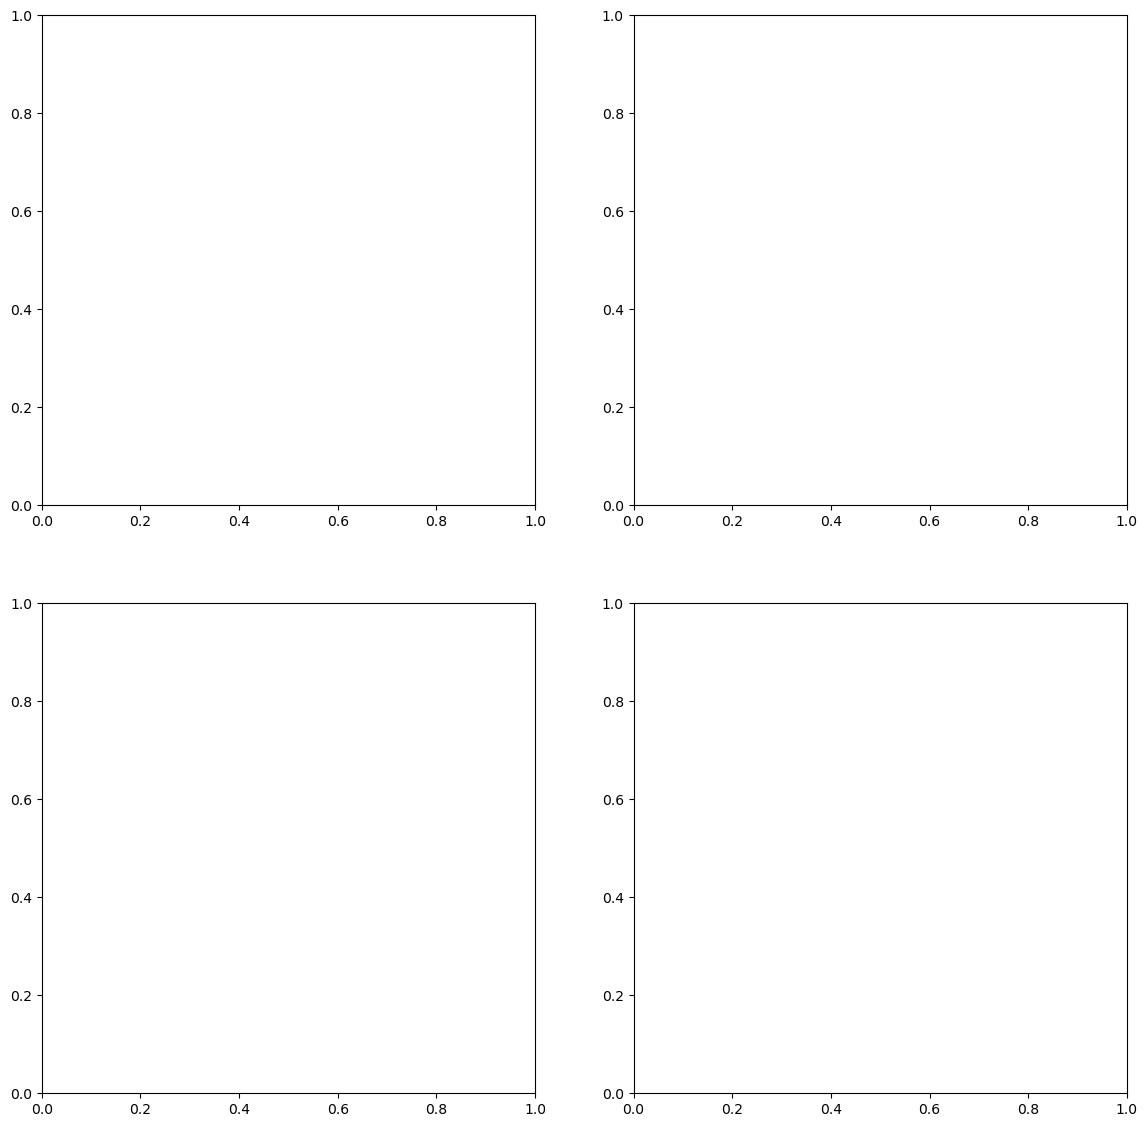

In [ ]:
file_paths = [
    '../data/Papua_Landsat_Image-0000000000-0000000000.tif',
    '../data/Papua_Landsat_Image-0000000000-0000005632.tif',
    '../data/Papua_Landsat_Image-0000005632-0000000000.tif',
    '../data/Papua_Landsat_Image-0000005632-0000005632.tif'
]

# Set up the plot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# Loop over files and plot each one in a grid position
for i, file_path in enumerate(file_paths):
    # Open the image
    with rio.open(file_path) as image:
        # Read and normalize the RGB bands (assuming bands 4, 3, and 2 correspond to RGB)
        rgb = image.read([4, 3, 2]) / 44343.0  # Adjust divisor based on your data's max value
        rgb = np.clip(rgb, 0, 1)

        # Calculate subplot row and column
        row, col = divmod(i, 2)
        
        # Plot the RGB image on the grid
        show(rgb, ax=axes[row, col], transform=image.transform)
        
        # Get and plot the boundary
        bounds = image.bounds
        crs = image.crs
        boundary = gpd.GeoDataFrame(
            {'geometry': [box(bounds.left, bounds.bottom, bounds.right, bounds.top)]},
            crs=crs
        )
        boundary.plot(facecolor="none", edgecolor='red', linewidth=2, ax=axes[row, col])

        # Set the title for each subplot
        axes[row, col].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [ ]:
sample_extract = sample.copy()
# False color composite
out_range = (0, 1)
red = rescale_intensity(image_data[4], in_range=(0, 0.3), out_range=out_range)  # Band 4 (Red)
green = rescale_intensity(image_data[3], in_range=(0, 0.3), out_range=out_range)  # Band 3 (Green)
blue = rescale_intensity(image_data[2], in_range=(0, 0.3), out_range=out_range)  # Band 2 (Blue)

arr_image = np.stack(
    [red, green, blue]
).T
composite = np.rot90(np.flip(arr_image, 1), 1)

# Plot landsat image
plt.imshow(composite)

# Extract raster value
raster_extract = np.stack(
    [x for x in tif_image.sample(coords)]
) / 1e4
sample_extract[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11']] = raster_extract
sample_extract

In [ ]:
# Split sample to train and test
seeds = 2
train, test = train_test_split(sample_extract, train_size=0.7, random_state=seeds)
print(f'Train size: {len(train)}\nTest size: {len(test)}')

In [ ]:
# Make random forest model
predictors = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
model = RandomForestClassifier(50)
model.fit(
    train[predictors],
    train['label']
)

In [ ]:
# Test model
test_apply = model.predict(test[predictors])

# Confusion matrix
cm = confusion_matrix(test['label'], test_apply)
display = ConfusionMatrixDisplay(cm)
display.plot()

# Report
report = classification_report(test['label'], test_apply)
print(report)

In [ ]:
# Load image
image_transpose = image_data.T
transpose_shape = image_transpose.shape
band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
table_image = pd.DataFrame(
    image_transpose.reshape(-1, transpose_shape[2]),
    columns=band_names,
)
table_image

In [ ]:
# Create an imputer object with a strategy to fill NaNs, e.g., with the mean value
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data
table_image_imputed = imputer.fit_transform(table_image[predictors])

# Predict with the imputed data
prediction = model.predict(table_image_imputed)
prediction

In [ ]:
# Plot landsat image
plt.imshow(composite)

# Prediction to image again
prediction = np.array(prediction, dtype=int) 
prediction_image = np.rot90(np.flip(prediction.reshape(transpose_shape[0], transpose_shape[1]), 1), 1)

cmap = ListedColormap(['green', 'yellow'])
legend_labels = [mpatches.Patch(color='green', label='non_tambang'), 
                    mpatches.Patch(color='yellow', label='tambang')]

# Show to plot
plt.figure(figsize=(5, 5))
plt.imshow(prediction_image, cmap=cmap, interpolation="nearest")
plt.legend(handles=legend_labels, loc='upper right')